## IV. Time Series Classification

Another significant task in time series analysis is **Time Series Classification (TSC)**. 

- The goal of TSC is to assign a class label to an entire time series instance
- Each time series is considered a single data point or observation.


**Examples of TSC tasks include:**
* Identifying human activities (e.g., walking, running, sitting) from accelerometer sensor data.
* Classifying ECG signals as normal or indicative of a particular heart condition.
* Recognizing spoken words from audio snippets.

This is distinct from forecasting, where we predict future values of a series. In TSC, we predict a single categorical label for the whole series.

### III.1. Panel Data - `sktime` data formats for collections of Time Series

For tasks like TSC, TSR, and clustering, we work with **collections of time series**, often referred to as **panel data**. An observation in panel data has values for:
* An **instance** (e.g., a patient, a trial, a specific day).
* One or more **variables** (e.g., blood pressure, accelerometer readings).
* A sequence of **time points** or indices.

`sktime` supports multiple in-memory formats for panel data. The two preferred formats are:

1.  **`pd-multiindex`**: A `pandas.DataFrame` with a 2-level `MultiIndex` (instance_id, time_id) and columns representing different variables. This format is flexible and can handle series of unequal lengths within the panel.
2.  **`numpy3D`**: A 3-dimensional `numpy.ndarray` with dimensions `(n_instances, n_variables, n_timepoints)`. This format assumes all series have the same length and the same time index.

In [1]:
import matplotlib.pyplot as plt

from sktime.datasets import load_italy_power_demand, load_basic_motions
from sktime.utils.plotting import plot_series

In [2]:
X_multi, y_multi_labels = load_italy_power_demand(return_type="pd-multiindex")

# Renaming for convenience
X_multi.columns = ["total_power_demand"]
X_multi.index.names = ["day_ID", "hour_of_day"]
X_multi.head(5)

total_power_demand
day_ID hour_of_day                    
0      0                     -0.710518
       1                     -1.183320
       2                     -1.372442
       3                     -1.593083
       4                     -1.467002

In [3]:
print(f"Shape: {X_multi.shape}")
print(f"Number of unique instances (days): {X_multi.index.get_level_values('day_ID').nunique()}")

Shape: (26304, 1)
Number of unique instances (days): 1096


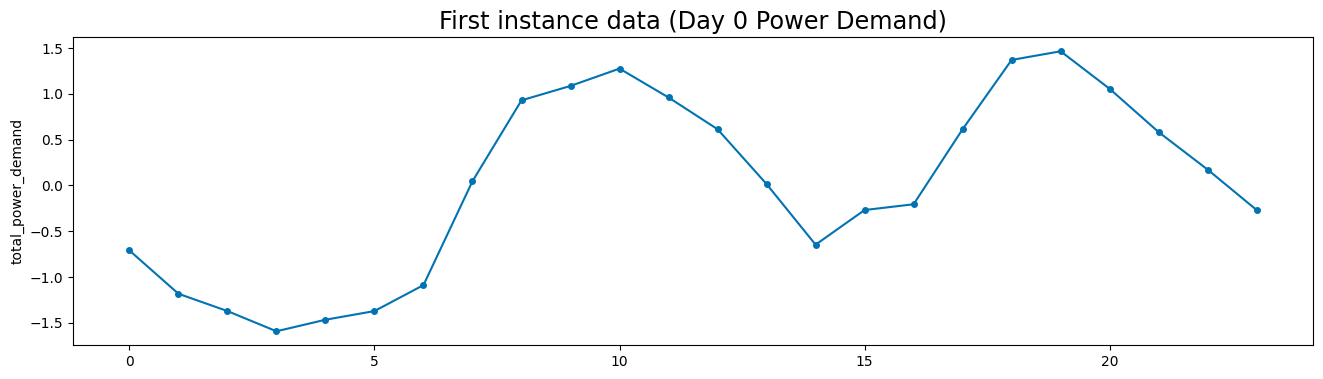

In [4]:
fig, ax = plot_series(
    X_multi.loc[0, "total_power_demand"], 
    title="First instance data (Day 0 Power Demand)"
)

The **dataset** has:
- 1096 daily power demand profiles (instances)
- each instance with 1 variable observed over 24 hourly time points 

In [5]:
X_3d, y_3d_labels = load_basic_motions(return_type="numpy3D")

In [6]:
print(f"Shape: {X_3d.shape}") # (n_instances, n_variables, n_timepoints)
print(f"Number of instances: {X_3d.shape[0]}")
print(f"Number of variables per instance: {X_3d.shape[1]}")
print(f"Number of timepoints per instance: {X_3d.shape[2]}")

Shape: (80, 6, 100)
Number of instances: 80
Number of variables per instance: 6
Number of timepoints per instance: 100


The **dataset** has: 

- 80 trials (instances)
- each instance has 6 variables (3 accelerometer, 3 gyroscope) observed over 100 time points

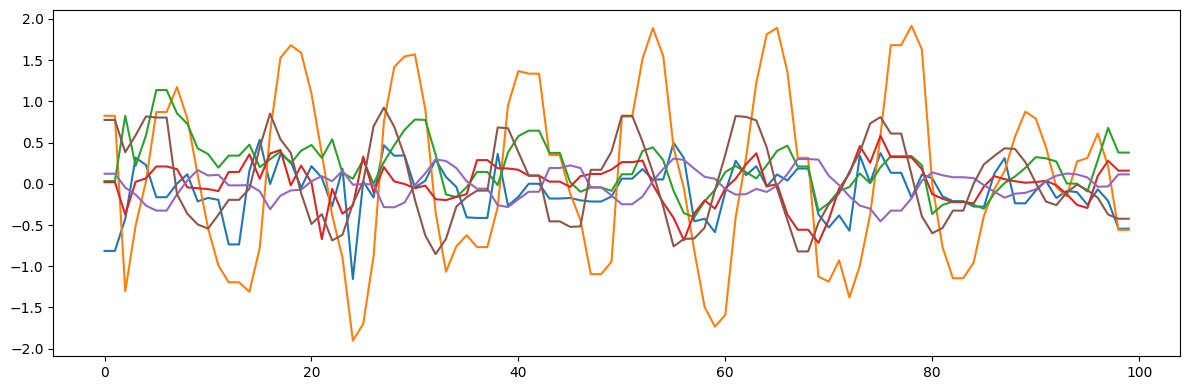

In [7]:
fig, ax = plt.subplots(1,1, figsize=(12,4))

for k, x in enumerate(X_3d[2]):
    ax.plot(x)

plt.tight_layout()
plt.show()

### III.2 Time Series classification


The workflow for TSC in sktime is very similar to scikit-learn's classification workflow:

- Load/prepare training data X (as a panel, e.g., numpy3D) and y (1D array of labels).
- Load/prepare new data X_new for prediction.
- Specify a sktime time series classifier.
- Fit the classifier to the training data: clf.fit(X_train, y_train).
- Predict labels on new data: y_pred = clf.predict(X_new).

#### III.5.A Distance-Based Classification

- The k-Nearest Neighbors Time Series Classifier (`KNeighborsTimeSeriesClassifier` or `FlatDist`) is a strong baseline. 

- It classifies a new time series by finding the $k$ most similar time series in the training data and assigning the majority class label among these neighbors.

- The "similarity" is measured using a time series distance metric, with Dynamic Time Warping (DTW) being a popular and effective choice (often the default).

In [8]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

from sktime.dists_kernels import FlatDist, ScipyDist
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [9]:
# Using numpy3D format for this example. Labels are strings '1', '2'.
X_panel, y_labels = load_italy_power_demand(return_X_y=True, return_type="numpy3D")


X_train, X_test, y_train, y_test = train_test_split(
    X_panel, y_labels, test_size=0.25, random_state=42, stratify=y_labels
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (822, 1, 24), y_train shape: (822,)
X_test shape: (274, 1, 24), y_test shape: (274,)


In [10]:
# k-NN with Euclidean distance on the flattened time series
euclidean_distance_on_series = FlatDist(ScipyDist(metric='euclidean'))
ts_classifier = KNeighborsTimeSeriesClassifier(n_neighbors=3, distance=euclidean_distance_on_series)

In [11]:
# Fit the classifier
ts_classifier.fit(X_train, y_train)
print(f"Classifier is fitted: {ts_classifier.is_fitted}")

Classifier is fitted: True


In [12]:
# Predict labels on new (test) data
y_pred = ts_classifier.predict(X_test)
print("\nFirst 10 predictions:", y_pred[:10])
print("First 10 true labels:", y_test[:10])


First 10 predictions: ['1' '1' '1' '2' '2' '1' '2' '2' '1' '2']
First 10 true labels: ['1' '1' '1' '2' '2' '1' '2' '2' '1' '1']


In [13]:
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy of KNeighborsTimeSeriesClassifier (Euclidean) on ItalyPowerDemand: {accuracy:.4f}")


Accuracy of KNeighborsTimeSeriesClassifier (Euclidean) on ItalyPowerDemand: 0.9781


In [14]:
print("\nClassification Report (KNN):")
print(classification_report(y_test, y_pred))


Classification Report (KNN):
              precision    recall  f1-score   support

           1       0.98      0.98      0.98       137
           2       0.98      0.98      0.98       137

    accuracy                           0.98       274
   macro avg       0.98      0.98      0.98       274
weighted avg       0.98      0.98      0.98       274



#### III.5.B. Feature-Based classification

This strategy involves two main steps:

- Feature Extraction: Transform each time series instance into a vector of features. These features can be simple summary statistics (mean, std, min, max), counts of peaks, measures of autocorrelation, spectral properties, etc.
- Tabular Classification: Apply a standard scikit-learn classifier (e.g., `RandomForestClassifier`, `SVM`) to the extracted features.

`sktime` provides transformers for feature extraction, and these can be pipelined with `scikit-learn` classifiers. `TSFreshRelevantFeatureExtractor` can extract and select a large number of features. For a simpler example, we can use `SummaryTransformer`.

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sktime.transformations.series.summarize import SummaryTransformer
from sktime.classification.compose import ClassifierPipeline

In [16]:
X, y = load_basic_motions(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# SummaryTransformer extracts mean, std, min, max for each series & dimension
feature_extractor = SummaryTransformer()
feature_extractor.fit_transform(X_train).head()

,dim_0__mean,dim_0__std,dim_0__min,dim_0__max,dim_0__0.1,dim_0__0.25,dim_0__0.5,dim_0__0.75,dim_0__0.9,dim_1__mean,...,dim_4__0.9,dim_5__mean,dim_5__std,dim_5__min,dim_5__max,dim_5__0.1,dim_5__0.25,dim_5__0.5,dim_5__0.75,dim_5__0.9
67,0.723536,1.466788,-2.201411,4.844779,-0.890409,-0.479800,0.551162,1.699260,2.599995,0.168381,...,0.409360,-0.010307,1.473439,-3.124136,2.697996,-1.882738,-1.422241,0.081233,1.205176,1.828405
31,4.862672,7.298625,-6.587615,29.363152,-1.452618,-0.032446,2.151706,6.979507,15.091264,-1.644168,...,2.939032,-0.325837,3.686728,-15.511481,5.784845,-4.791673,-0.358890,0.379530,1.043376,2.870583
7,-0.126128,0.145672,-0.435080,0.301496,-0.303203,-0.221936,-0.141425,-0.044941,0.060976,0.149755,...,0.095881,-0.005140,0.410459,-0.719111,0.719111,-0.532941,-0.391515,0.013317,0.321602,0.548655
58,6.549981,10.002434,-14.664149,20.634491,-9.261630,-2.984639,9.507253,14.184290,17.774416,-4.530688,...,2.603713,0.194107,5.498750,-8.722545,9.569497,-6.845400,-4.916586,-0.069248,5.578434,7.221202
1,-0.140619,0.686319,-0.909276,4.310925,-0.399097,-0.342918,-0.287704,-0.170549,-0.023033,-0.056105,...,0.056197,-0.102407,0.664503,-4.176168,1.105300,-0.239704,-0.167792,-0.034624,0.152478,0.235176


##### The classifier pipeline

In [17]:
feature_extractor = SummaryTransformer()

tabular_classifier_rf = RandomForestClassifier(n_estimators=100, random_state=42)

feature_based_pipeline = feature_extractor * tabular_classifier_rf

feature_based_pipeline.fit(X_train, y_train)

y_pred_feature_based = feature_based_pipeline.predict(X_test)

accuracy_feature_based = accuracy_score(y_test, y_pred_feature_based)

print(f"\nFeature-Based Pipeline Accuracy on BasicMotions: {accuracy_feature_based:.4f}")
print(classification_report(y_test, y_pred_feature_based))


Feature-Based Pipeline Accuracy on BasicMotions: 1.0000
              precision    recall  f1-score   support

   badminton       1.00      1.00      1.00         5
     running       1.00      1.00      1.00         5
    standing       1.00      1.00      1.00         5
     walking       1.00      1.00      1.00         5

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



#### Summary

As demonstrated in the feature-based example, sktime enables the creation of powerful pipelines for Time Series Classification. You can chain multiple sktime transformers (for preprocessing, feature extraction, dimensionality reduction, etc.) with a final classifier (which can be an sktime native time series classifier or a scikit-learn classifier if features are extracted).

This approach ensures that all steps are consistently applied and allows for joint optimization of the entire pipeline if hyperparameter tuning is performed.